### LOADING LIBRARIES

In [91]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import os
import re 
import datetime as dt
from datetime import datetime
import time
import random
from parrot import Parrot
import torch
from keras.models import save_model
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations

from nltk.tokenize import WordPunctTokenizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
 


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### SETTING KERNAL PATH

In [2]:
os.chdir(r'D:\MastersCollege\Semister 2\Study Materials\Intro_to_DS\Assignment\Notebook\data\raw')

### LOADING DATAFRAME

In [3]:
Data_res = pd.read_csv('Restaurant name and related info.csv')
Data_review  = pd.read_csv('Restaurant_Review.csv')

In [4]:
Data_res = Data_res.drop_duplicates(keep='last').reset_index(drop=True)
Data_review = Data_review.drop_duplicates(keep='last').reset_index(drop=True)

### DATA DESCRIBE

In [5]:
Data_res.shape
print('*'*100)
Data_res.columns
print('*'*100)
Data_review.shape
print('*'*100)
Data_review.columns

(105, 6)

****************************************************************************************************


Index(['Name', 'Links', 'Cost', 'Collections', 'Cuisines', 'Timings'], dtype='object')

****************************************************************************************************


(9964, 7)

****************************************************************************************************


Index(['Restaurant', 'Reviewer', 'Review', 'Rating', 'Metadata', 'Time',
       'Pictures'],
      dtype='object')

In [6]:
Data_res.describe()

Name                                              Links  \
count               105                                                105   
unique              105                                                105   
top     Beyond Flavours  https://www.zomato.com/hyderabad/beyond-flavou...   
freq                  1                                                  1   

       Cost                                  Collections  \
count   105                                           51   
unique   29                                           42   
top     500  Food Hygiene Rated Restaurants in Hyderabad   
freq     13                                            4   

                     Cuisines         Timings  
count                     105             104  
unique                     92              77  
top     North Indian, Chinese  11 AM to 11 PM  
freq                        4               6

In [7]:
#Approach 1 
# Drop Cuisines as 50% of the data is missing.
# Data_res = Data_res.drop(columns='Collections')

In [8]:
# #Approach 2 : - Using a sentence rephrasing trained T5 (Text-to-Text Transfer Transformer) pretrained model. 
# Particularly, under the hood PARROT’s paraphrasing technology is based on the T5 algorithm (an acronym for Text-To-Text Transfer Transformer) that was originally developed by Google (for more information refer to the T5 resource at Papers with Code). At a high-level, text generation is niche area of the exciting area of natural language processing (NLP),
# which is generally referred to as artificial intelligence or AI when explained to the general audience.

### PARAPHRASING T5 MODEL, USING PARROT LIBRARY (servers API utility), IMPLEMENTS NLG(natural language generation) TO IMPUTE UNIQUE SENSIBLE SENTENCES 

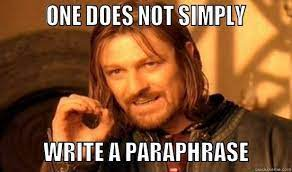

In [9]:
def random_state(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

random_state(1234)

### LOADING TEXT PARAPHRASING MODEL

In [10]:
parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5", use_gpu=True)

In [11]:
rand_collections = [random.choice(Data_res[(~Data_res['Collections'].isna())]['Collections'].to_list()) for x in range(0, Data_res['Collections'].isna().sum())]

In [12]:
rephrased_list = []
for phrases in rand_collections:
    phrases = [phrases]
    try:
        selector = random.choice(np.arange(0, 5))
        for phrase in phrases:
            para_phrases = parrot.augment(input_phrase=phrase)
            para_sent = para_phrases[selector][0]
            rephrased_list.append(para_sent)
    except:
        for phrase in phrases:
            para_phrases = parrot.augment(input_phrase=phrase)
            para_sent = para_phrases[0][0]
            rephrased_list.append(para_sent)

In [13]:
Data_res.loc[Data_res['Collections'].isna(), 'Collections'] = rephrased_list

### WE COULD SEE HEAD TO HEAD COMPARISON BETWEEN SENTENCES 

In [14]:
dict(zip(rand_collections,rephrased_list))

{'Food Hygiene Rated Restaurants in Hyderabad': 'Food Hygiene Rated Restaurants in Hyderabad',
 'Great Buffets, Trending This Week': 'Great Buffets, Trending This Week',
 'Frozen Delights': 'frozen delights',
 'Barbecue & Grill': 'barbecue grill',
 'Top-Rated, Gold Curated, Fancy and Fun': 'Top-Rated, Gold Curated, Fancy and Fun',
 'Best Milkshakes': 'milkshakes are the best',
 'Barbecue & Grill, Live Sports Screenings': 'grill bbq live sports screenings',
 "Hyderabad's Hottest": "hyderabad's hottest metropolis",
 "Food Hygiene Rated Restaurants in Hyderabad, Great Buffets, Hyderabad's Hottest": "Food Hygiene Rated Restaurants in Hyderabad, Great Buffets, Hyderabad's Hottest",
 'Sneak Peek Hyderabad, Best Bars & Pubs, Gigs and Events': 'Sneak Peek Hyderabad, Best Bars & Pubs, Gigs and Events',
 'Veggie Friendly, Terrific Thalis': 'Veggie Friendly, Terrific Thalis',
 "Barbecue & Grill, Great Buffets, Corporate Favorites, Hyderabad's Hottest": "barbecue grill great buffets corporate favo

#### As only one missing value was there , it was making sense to impute Mode as most of the restruants will be similar time bracket. 

In [15]:
Data_res['Timings'].fillna(Data_res['Timings'].mode()[0], inplace=True)

### REMOVING EXTRA WHITE SPACES FROM THE RESTAURANT NAME COLUMN

In [16]:
Data_res.reset_index(drop=True, inplace=True)
Data_res['Name'] = Data_res['Name'].apply(lambda x:x.strip())

In [17]:
Data_res.columns

Index(['Name', 'Links', 'Cost', 'Collections', 'Cuisines', 'Timings'], dtype='object')

In [18]:
#Renaming Columns
Data_res.columns = ['Restaurant','Links','Cost','Collections','Cuisines','Rest_Timings']

In [19]:
#Preparing Reviews DF

### printing missing values in percent for Review data

In [20]:

percent_missing = Data_review.isnull().sum() * 100 / len(Data_review)
missing_value_df = pd.DataFrame({'column_name': Data_review.columns,
                                 'percent_missing': percent_missing})

In [21]:
display(missing_value_df)

column_name  percent_missing
Restaurant  Restaurant         0.000000
Reviewer      Reviewer         0.020072
Review          Review         0.090325
Rating          Rating         0.020072
Metadata      Metadata         0.020072
Time              Time         0.020072
Pictures      Pictures         0.000000

In [22]:
#For all the columns not even more 1% percent data is missing, hence there will be no loss of information even if we drop those but we wont.


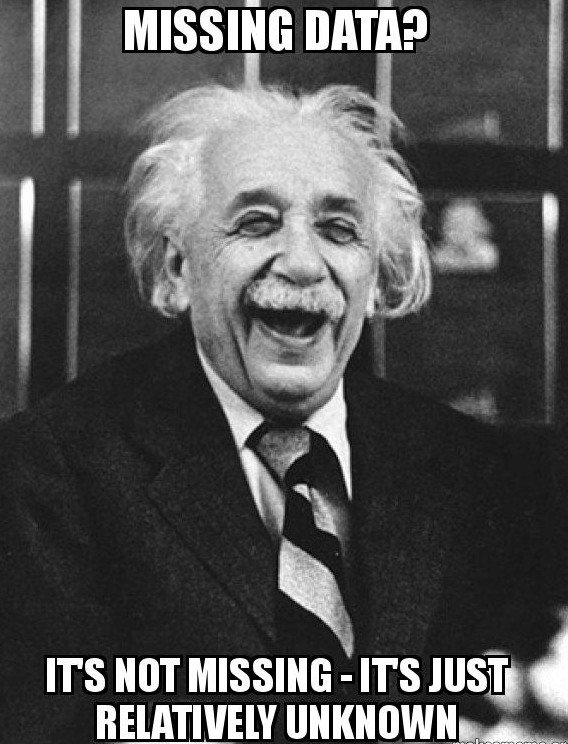

### SO LETS IMPUTE THE DATA RANDOM FROM THE EXISTING ONES AND KEEP THE DISTRIBUTION SAME

## Building a custom function 

In [23]:

def rand_imputer(Data, col):
    rand_list = [random.choice(Data[~Data[col].isna()][col].to_list()) for x in range(0, Data[col].isna().sum())]
    Data.loc[Data[col].isna(), col] = rand_list
    return Data

In [24]:
#Impute all columns in Loop Sequence.
for col in Data_review.columns:
    Data_review = rand_imputer(Data_review, col)

In [25]:
Data_review.reset_index(drop=True, inplace=True)

In [26]:
Data_review.isna().sum()

Restaurant    0
Reviewer      0
Review        0
Rating        0
Metadata      0
Time          0
Pictures      0
dtype: int64

### Stripping white spaces 

In [27]:

Data_review['Restaurant'] = Data_review['Restaurant'].apply(lambda x:x.strip())

### Working on Meta Data column 

In [28]:
#In the given meta data there are two types of info
# X reviewers and Y followers
#        &
# X  reviewers 
#Thus whereever there will be single number extracted in the list, it has to be reviewers.

In [29]:
Data_review.head()

Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review Rating  \
0  The ambience was good, food was quite good . h...      5   
1  Ambience is too good for a pleasant evening. S...      5   
2  A must try.. great food great ambience. Thnx f...      5   
3  Soumen das and Arun was a great guy. Only beca...      5   
4  Food is good.we ordered Kodi drumsticks and ba...      5   

                  Metadata             Time  Pictures  
0   1 Review , 2 Followers  5/25/2019 15:54       0.0  
1  3 Reviews , 2 Followers  5/25/2019 14:20       0.0  
2  2 Reviews , 3 Followers  5/24/2019 22:54       0.0  
3    1 Review , 1 Follower  5/24/2019 22:11       0.0  
4  3 Reviews , 2 Followers  5/24/2019 21:37       0.0

### Understanding pattern and spliting by Comma, number before comma is Review and after is Follower. 

In [30]:
Meta_main = []
for meta in range(0, Data_review['Metadata'].shape[0]):
    meta_li = [int(s) for s in Data_review['Metadata'][meta].split() if s.isdigit()]
    Meta_main.append(meta_li)

In [31]:
len(Meta_main)

9964

In [32]:
#Creating a temp dataframe 
meta_df = pd.DataFrame(Meta_main, columns = ['Reviews', 'Followers']) 

In [33]:
#Filling Null values.

meta_df['Followers'] = meta_df['Followers'].fillna(0)
meta_df['Followers'] = meta_df['Followers'].astype(int)

In [34]:
#Concatenating Meta and Base Review DFs.
Data_review_meta = pd.concat([Data_review,meta_df], 1, ignore_index=False).reset_index(drop=True)

In [35]:
#Drop the existing Metadata column
Data_review_meta.drop(['Metadata'],1, inplace=True) 

In [36]:
#Assuming the time of review column as Review done just after few minutes of dinning from the restraurants. 

In [37]:
os.chdir(r'D:\MastersCollege\Semister 2\Study Materials\Intro_to_DS\Assignment\Notebook\data\processed')

In [38]:
Data_review_meta.to_excel('Data_review_meta.xlsx',index=False)

In [39]:
Data_res.head()

Restaurant  \
0                 Beyond Flavours   
1                        Paradise   
2                        Flechazo   
3  Shah Ghouse Hotel & Restaurant   
4      Over The Moon Brew Company   

                                               Links   Cost  \
0  https://www.zomato.com/hyderabad/beyond-flavou...    800   
1  https://www.zomato.com/hyderabad/paradise-gach...    800   
2  https://www.zomato.com/hyderabad/flechazo-gach...  1,300   
3  https://www.zomato.com/hyderabad/shah-ghouse-h...    800   
4  https://www.zomato.com/hyderabad/over-the-moon...  1,200   

                                         Collections  \
0  Food Hygiene Rated Restaurants in Hyderabad, C...   
1                                Hyderabad's Hottest   
2                 Great Buffets, Hyderabad's Hottest   
3                             Late Night Restaurants   
4  Best Bars & Pubs, Food Hygiene Rated Restauran...   

                                            Cuisines  \
0  Chinese, Continental, Kebab, European, South I...   
1                     Biryani, North Indian, Chinese   
2       Asian, Mediterranean, North Indian, Desserts   
3  Biryani, North Indian, Chinese, Seafood, Bever...   
4  Asian, Continental, North Indian, Chinese, Med...   

                                        Rest_Timings  
0      12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)  
1                                     11 AM to 11 PM  
2              11:30 AM to 4:30 PM, 6:30 PM to 11 PM  
3                                    12 Noon to 2 AM  
4  12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no...

In [40]:
#Cleaning Rate Column 
Data_review_meta.loc[Data_review_meta['Rating']=='Like','Rating'] = 5

In [41]:
#Changing Datatype of Rating.
Data_review_meta['Rating'] = [float(x) for x in Data_review_meta['Rating']]

In [42]:
#Covert Cost Column from String (removing punct) to Float.
Data_res['Cost'] = Data_res['Cost'].apply(lambda x: float(''.join([i for i in x if i not in string.punctuation])))

In [43]:
#Dropping Links as it is less significant feature.
Data_res.drop('Links',1,inplace=True)

In [44]:
#Droppping duplicate rows, keeping unique restaurants.
Data_res.drop_duplicates(subset='Restaurant', keep='last').shape

(105, 5)

### Grouping Review Dataframe Restaurant wise and Aggregating them as required.

In [45]:
Data_review_meta_grp = Data_review_meta.groupby('Restaurant').agg({'Reviewer':'nunique','Review':'sum','Rating':'mean','Pictures':'sum','Reviews':'sum',
                                                                   'Followers':'sum'}).reset_index()

In [46]:
#Renaming Columns
Data_review_meta_grp.columns = ['Restaurant','Uniq_usercomments_Count','Review','Mean_Rating','Pictures','Reviews','Followers']

### MERGING TWO DATAFRAMES INTO ONE ENTITY

In [47]:
Data_final = Data_res.merge(Data_review_meta_grp, how='inner').reset_index(drop=True)

### SCALING mean RATING COLUMN

In [48]:
scaler = MinMaxScaler(feature_range = (1,5))
Data_final[['Mean_Rating']] = scaler.fit_transform(Data_final[['Mean_Rating']]).round(2)

In [49]:
## Lower Casing
Data_final["Review"] = Data_final["Review"].str.lower()

###  Removal of Puctuations 

In [50]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    return text

Data_final["Review"] = Data_final["Review"].apply(lambda text: remove_punctuation(text))

### Removal of STOPWORDS

In [51]:

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

Data_final["Review"] = Data_final["Review"].apply(lambda text: remove_stopwords(text))

### Using Regex to find link like patterns and removing them 

In [52]:
#Cleaning URL
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

Data_final["Review"] = Data_final["Review"].apply(lambda text: remove_urls(text))

In [53]:
Data_final.columns

Index(['Restaurant', 'Cost', 'Collections', 'Cuisines', 'Rest_Timings',
       'Uniq_usercomments_Count', 'Review', 'Mean_Rating', 'Pictures',
       'Reviews', 'Followers'],
      dtype='object')

### Most Famous restaurant chains in Banglore

<Figure size 864x720 with 0 Axes>

<AxesSubplot:xlabel='Reviews', ylabel='Restaurant'>

Text(0.5, 1.0, 'Most famous restaurants chains in Hyderabad')

Text(0.5, 0, 'Number of Reviewers')

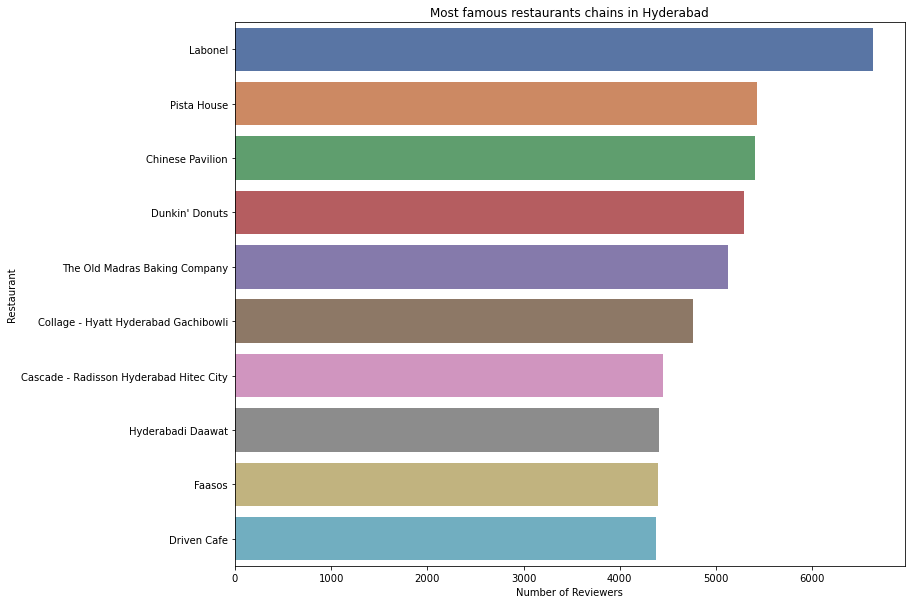

In [54]:

plt.figure(figsize=(12,10))
y = Data_final[['Restaurant','Reviews']].sort_values(by='Reviews', ascending=False)['Restaurant'].reset_index(drop=True)[:10]
x = Data_final[['Restaurant','Reviews']].sort_values(by='Reviews', ascending=False)['Reviews'].reset_index(drop=True)[:10]
sns.barplot(x,y,palette='deep',orient = 'h')
plt.title("Most famous restaurants chains in Hyderabad")
plt.xlabel("Number of Reviewers")

<Figure size 648x864 with 0 Axes>

<AxesSubplot:xlabel='Followers', ylabel='Restaurant'>

Text(0.5, 1.0, 'Most famous restaurants chains in Hyderabad')

Text(0.5, 0, 'Number of Followers')

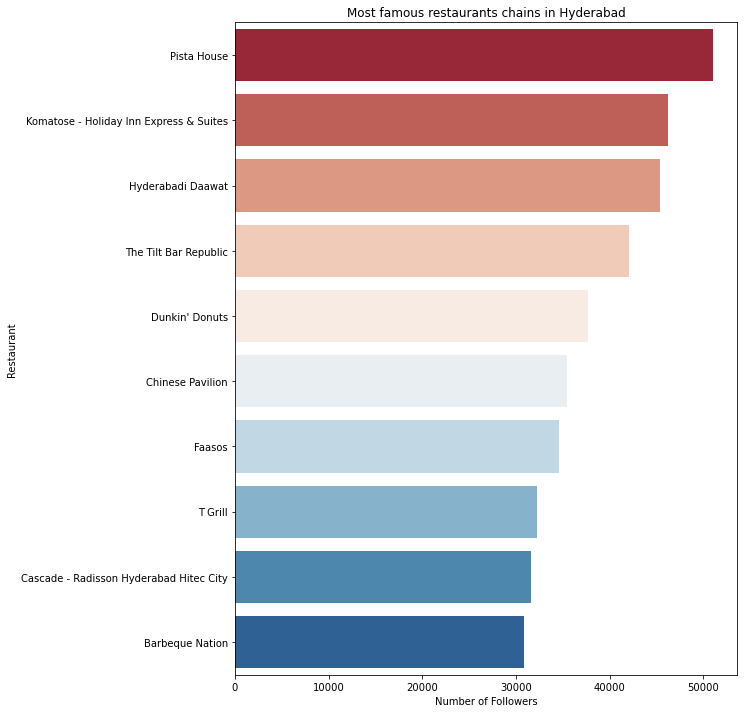

In [133]:
#Most Famous restaurant chains in Banglore
plt.figure(figsize=(9,12))
y = Data_final[['Restaurant','Followers']].sort_values(by='Followers', ascending=False)['Restaurant'].reset_index(drop=True)[:10]
x = Data_final[['Restaurant','Followers']].sort_values(by='Followers', ascending=False)['Followers'].reset_index(drop=True)[:10]
sns.barplot(x,y,palette='RdBu',orient = 'h')
plt.title("Most famous restaurants chains in Hyderabad")
plt.xlabel("Number of Followers")

### UNIQUE REVIEWERS WHO COMMENTED REVIEWS

### 7446 userids

In [56]:
Data_review_meta['Reviewer'].nunique()

7446

In [57]:
Data_review_meta.columns

Index(['Restaurant', 'Reviewer', 'Review', 'Rating', 'Time', 'Pictures',
       'Reviews', 'Followers'],
      dtype='object')

### Historgram showing distributions for Restaurant Rating and its Mean

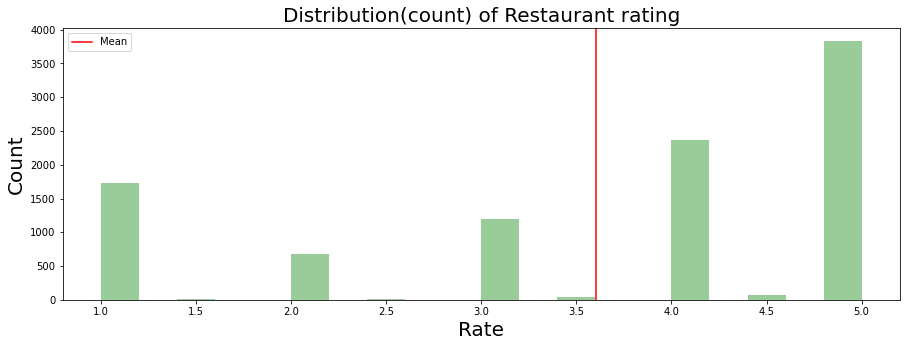

In [58]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.distplot(Data_review_meta.Rating,kde=False,color = 'g',ax =ax,bins=20)
ax.axvline(Data_review_meta.Rating.mean(), 0, 1, color='r', label='Mean')
ax.legend();
ax.set_ylabel('Count',size=20)
ax.set_xlabel('Rate',size=20)
ax.set_title('Distribution(count) of Restaurant rating',size=20);

### Top 15 Rated Restaurants in Hyderabad

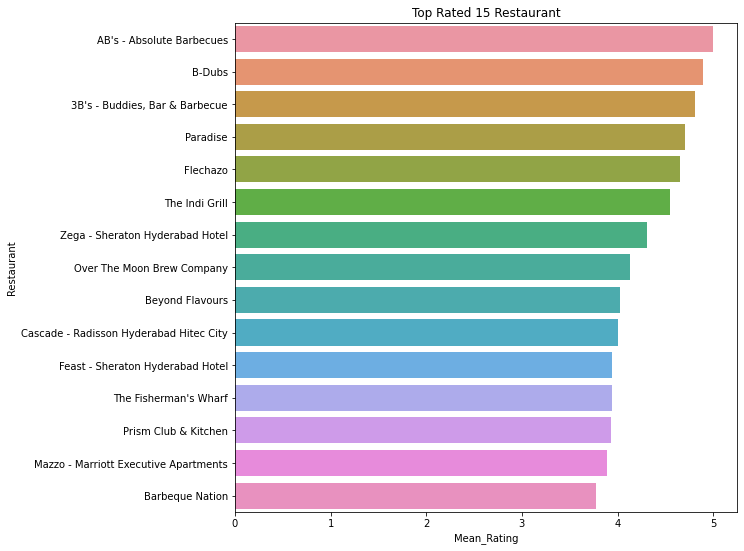

In [59]:
df_rating = Data_final.sort_values(by='Mean_Rating', ascending=False).head(15)
plt.figure(figsize=(9,9))
sns.barplot(data=df_rating, x='Mean_Rating', y='Restaurant')
plt.title('Top Rated 15 Restaurant');

In [60]:
Data_final.columns

Index(['Restaurant', 'Cost', 'Collections', 'Cuisines', 'Rest_Timings',
       'Uniq_usercomments_Count', 'Review', 'Mean_Rating', 'Pictures',
       'Reviews', 'Followers'],
      dtype='object')

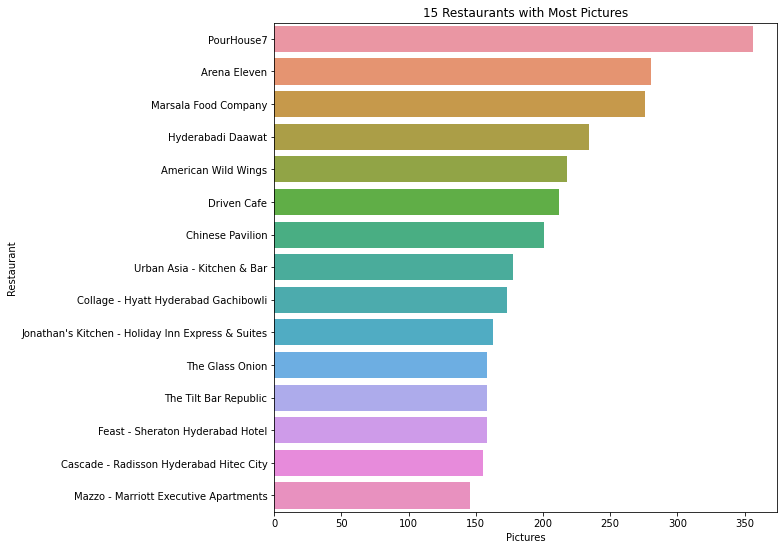

In [119]:
df_pictures = Data_final.sort_values(by='Pictures', ascending=False).head(15)
plt.figure(figsize=(9,9))
sns.barplot(data=df_pictures, x='Pictures', y='Restaurant')
plt.title('15 Restaurants with Most Pictures');

## Vectorizing each unique word a.k.a. (Cuisines) and taking the count of number of occurances in any doc explains the importance of words can be done using count vectorizer

### VECTORIZING IS DONE TO EXTRACT THE IMPORTANT FEATURES FROM THE TEXT PERHAPS, THERE ARE MANY LANGUAGE MODELS THAT UNDERSTANDS GRAMMER, WHAT PARTS OF SPEECH IS. LIKE (NAME ENTITY RECOGNITION) MODELS using Spacy MODEL, NLU/NLG chatbots using RASA 

In [61]:
def get_top_words(column, top_nu_of_words, nu_of_word):
    vec = CountVectorizer(ngram_range= nu_of_word, stop_words='english')
    bag_of_words = vec.fit_transform(column)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_nu_of_words]

### Top 15 two-words (bigrams) frequencies for Cuisines in Hyderabad

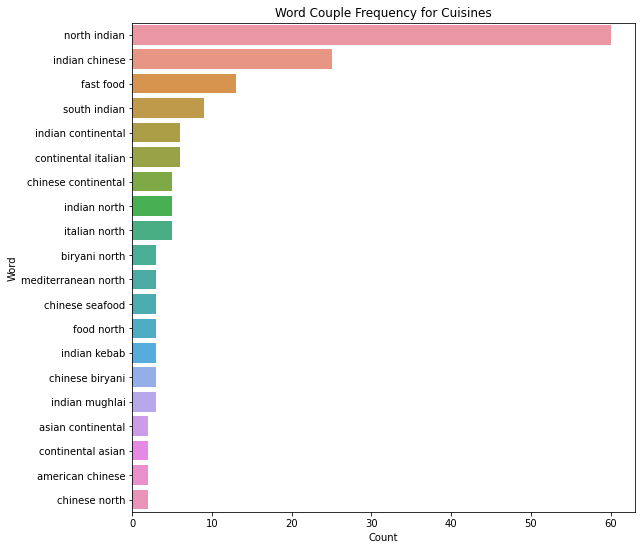

In [62]:

lst = get_top_words(Data_final['Cuisines'], 20, (2,2))
df_words = pd.DataFrame(lst, columns=['Word', 'Count'])

plt.figure(figsize=(9,9))
sns.barplot(data=df_words, x='Count', y='Word')
plt.title('Word Couple Frequency for Cuisines');

### These are most prominent or frequent words in a body of text column Review

<Figure size 1152x576 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

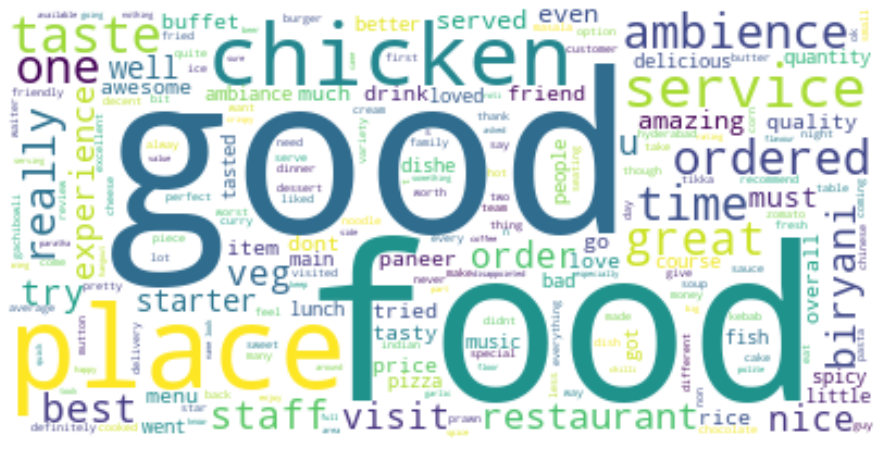

In [63]:
text = " ".join(rev for rev in Data_final["Review"])
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')


### These are most prominent or frequent words in a body of text column Collections

<Figure size 1152x576 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

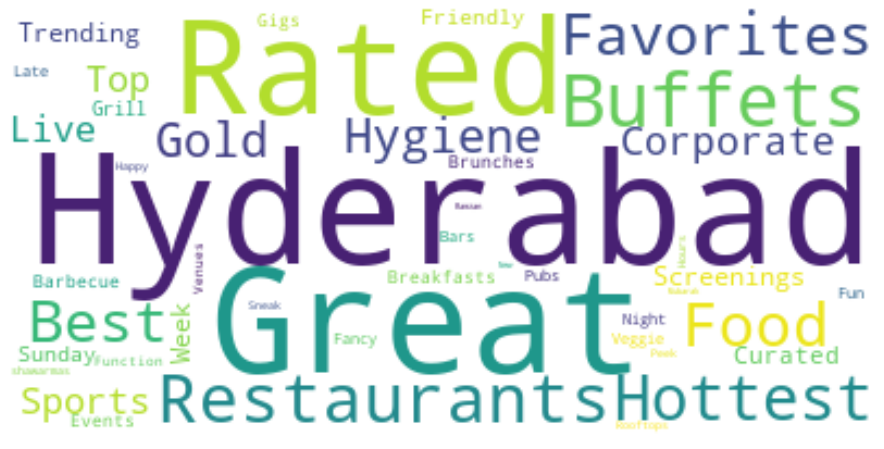

In [64]:
text = " ".join(rev for rev in Data_final["Collections"])
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text)



plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')



### JUSTIFICATION : " I could have dropped Collection column as 53% of data was missing and in real life scenarios we could prefer that. However I found that column with fancy Hotel nick names famous around the social paradigm".
### Hence only till EDA perspective this column is been considered and has been not used in Matrix Factorization in Collabarative Filtering part. 

## Reference Below Code is carried out considering Similar Cuisines, Rating and Reviews.  

### APPROACH 1 : CONTENT BASED RECOMMENDATION ENGINE 

In [65]:
df_percent = Data_final.copy()

In [66]:
df_percent.columns

Index(['Restaurant', 'Cost', 'Collections', 'Cuisines', 'Rest_Timings',
       'Uniq_usercomments_Count', 'Review', 'Mean_Rating', 'Pictures',
       'Reviews', 'Followers'],
      dtype='object')

In [67]:
df_percent.set_index('Restaurant', inplace=True)
indices = pd.Series(df_percent.index)

### TF-IDF can be broken down into two parts TF (term frequency) and IDF (inverse document frequency).

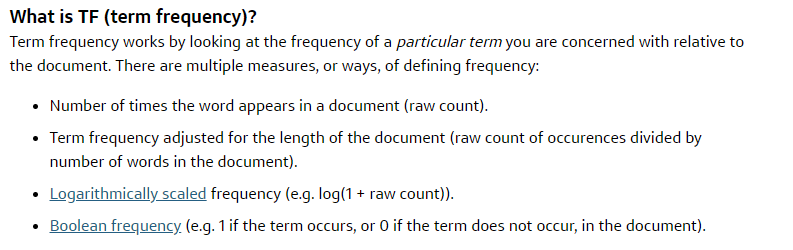

In [68]:
print("x-"*62)

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-


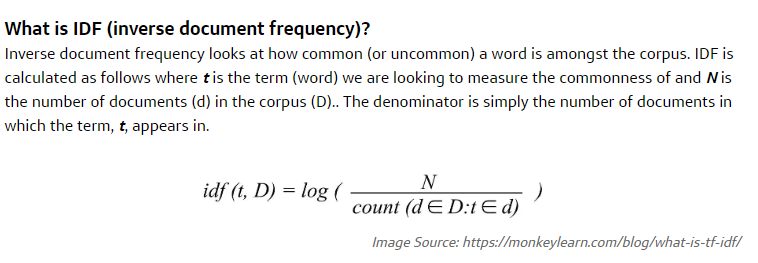

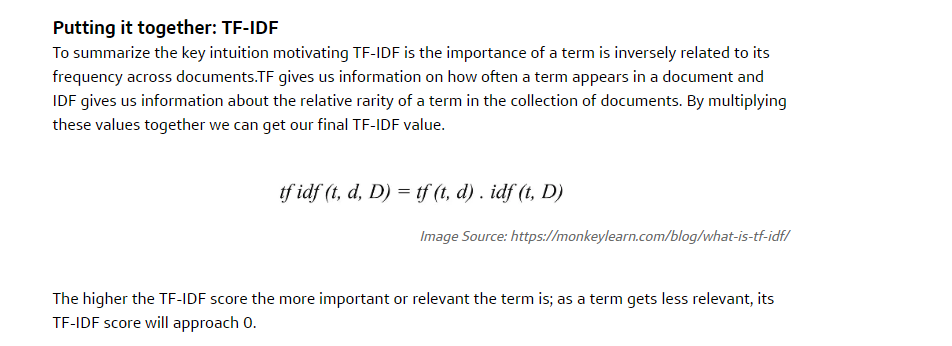

In [69]:
# Creating tf-idf bag of words matrix
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_percent['Review'])

In [70]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

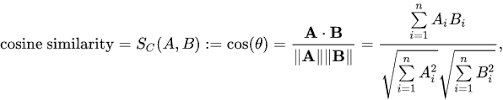


In [71]:
cosine_similarities

array([[1.        , 0.35213278, 0.29445158, ..., 0.27650509, 0.11292106,
        0.25335997],
       [0.35213278, 1.        , 0.30680005, ..., 0.27463389, 0.11415175,
        0.25233091],
       [0.29445158, 0.30680005, 1.        , ..., 0.27098645, 0.0889304 ,
        0.22546964],
       ...,
       [0.27650509, 0.27463389, 0.27098645, ..., 1.        , 0.09712162,
        0.26040339],
       [0.11292106, 0.11415175, 0.0889304 , ..., 0.09712162, 1.        ,
        0.10262988],
       [0.25335997, 0.25233091, 0.22546964, ..., 0.26040339, 0.10262988,
        1.        ]])

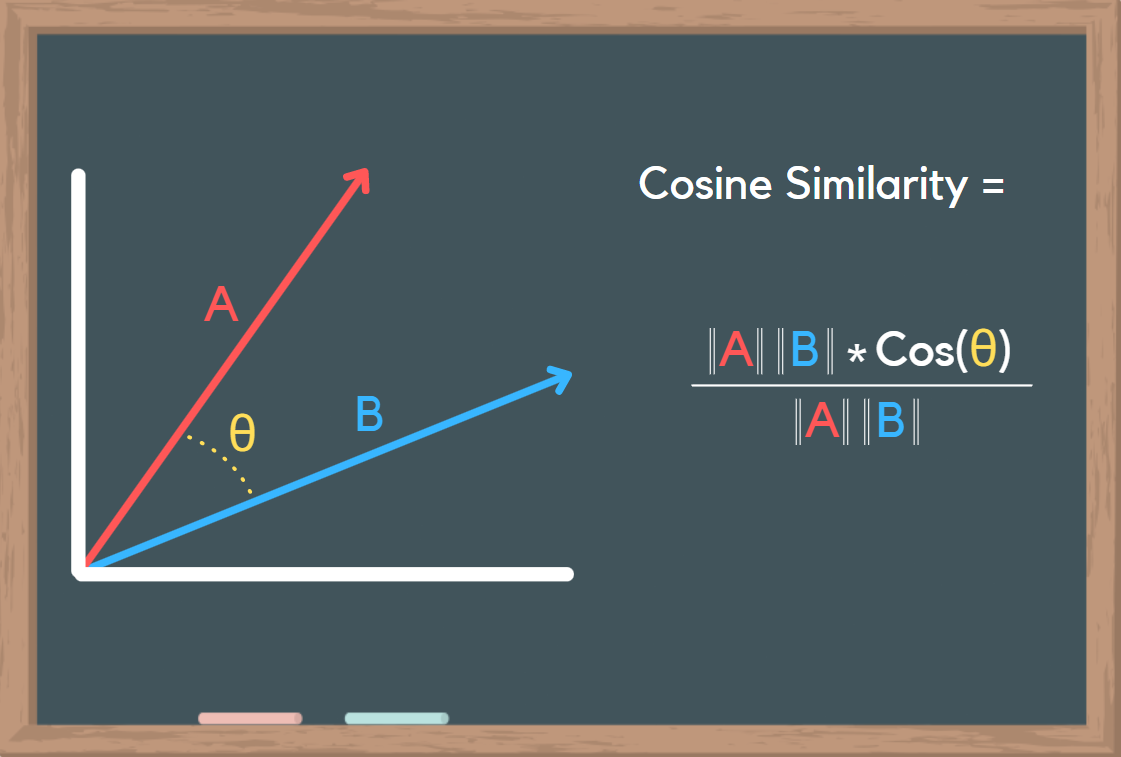

In [72]:
Data_final.columns

Index(['Restaurant', 'Cost', 'Collections', 'Cuisines', 'Rest_Timings',
       'Uniq_usercomments_Count', 'Review', 'Mean_Rating', 'Pictures',
       'Reviews', 'Followers'],
      dtype='object')

In [73]:
def recommend(name, cosine_similarities = cosine_similarities):
   
    recommend_restaurant = []
    
    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]
    
    # Find the restaurants with a similar cosine-sim value and order them from bigges number    
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    
    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)
    
    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])
    
    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['Cuisines', 'Mean_Rating', 'Cost','Rest_Timings'])
    
    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(df_percent[['Cuisines', 'Mean_Rating', 'Cost','Rest_Timings']][df_percent.index == each].sample()))
    
    # Drop the same named restaurants and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['Cuisines', 'Mean_Rating', 'Cost','Rest_Timings'], keep=False).reset_index()
    df_new.columns = ['Restaurant','Cuisines', 'Mean_Rating', 'Cost','Rest_Timings']
    df_new = df_new.sort_values(by='Mean_Rating', ascending=False).reset_index(drop=True).head(11)
    
    print('TOP %s RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ' % (str(len(df_new)), name))
    
    return df_new[df_new['Restaurant']!=name].reset_index(drop=True)

In [74]:
Data_final[Data_final['Restaurant']=='Flechazo']
recommend('Flechazo')

Restaurant    Cost                         Collections  \
2   Flechazo  1300.0  Great Buffets, Hyderabad's Hottest   

                                       Cuisines  \
2  Asian, Mediterranean, North Indian, Desserts   

                            Rest_Timings  Uniq_usercomments_Count  \
2  11:30 AM to 4:30 PM, 6:30 PM to 11 PM                      100   

                                              Review  Mean_Rating  Pictures  \
2  4 people visited place thursday nightambience ...         4.65      55.0   

   Reviews  Followers  
2      667       2748

TOP 11 RESTAURANTS LIKE Flechazo WITH SIMILAR REVIEWS: 


Restaurant  \
0                AB's - Absolute Barbecues   
1                                 Paradise   
2                           The Indi Grill   
3          Zega - Sheraton Hyderabad Hotel   
4               Over The Moon Brew Company   
5                          Beyond Flavours   
6  Cascade - Radisson Hyderabad Hitec City   
7                    The Fisherman's Wharf   
8         Feast - Sheraton Hyderabad Hotel   
9                             Arena Eleven   

                                            Cuisines  Mean_Rating    Cost  \
0              European, Mediterranean, North Indian         5.00  1500.0   
1                     Biryani, North Indian, Chinese         4.71   800.0   
2                          BBQ, Asian, Modern Indian         4.55  1500.0   
3                                       Asian, Sushi         4.31  1750.0   
4  Asian, Continental, North Indian, Chinese, Med...         4.13  1200.0   
5  Chinese, Continental, Kebab, European, South I...         4.03   800.0   
6          North Indian, Italian, Continental, Asian         4.00  1800.0   
7    Seafood, Goan, North Indian, Continental, Asian         3.94  1500.0   
8         Modern Indian, Asian, Continental, Italian         3.94  2500.0   
9                                        Continental         3.77  1600.0   

                                        Rest_Timings  
0            12 Noon to 4:30 PM, 6:30 PM to 11:30 PM  
1                                     11 AM to 11 PM  
2                           12noon to 11pm (Mon-Sun)  
3                            12Noon to 2AM (Mon-Sun)  
4  12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no...  
5      12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)  
6                                           24 Hours  
7  12Noon to 3:30PM, 4PM to 6:30PM, 7PM to 11:30P...  
8  6:30am to 10:30am, 12:30pm to 3pm, 7pm to 11pm...  
9                             12 Noon to 12 Midnight

In [75]:
Data_final[Data_final['Restaurant']=='KFC']
recommend('KFC')

Restaurant   Cost                        Collections           Cuisines  \
15        KFC  500.0  Great Buffets, Trending This Week  Burger, Fast Food   

      Rest_Timings  Uniq_usercomments_Count  \
15  11 AM to 11 PM                      100   

                                               Review  Mean_Rating  Pictures  \
15  good atmosphere eat relaxtastes goodquality go...         1.73      16.0   

    Reviews  Followers  
15     1341      12823

TOP 11 RESTAURANTS LIKE KFC WITH SIMILAR REVIEWS: 


Restaurant                                     Cuisines  \
0              Paradise               Biryani, North Indian, Chinese   
1          Arena Eleven                                  Continental   
2   American Wild Wings           American, Fast Food, Salad, Burger   
3                  GD's                             Burger, American   
4             KS Bakers                  Bakery, Desserts, Fast Food   
5            PourHouse7  North Indian, Continental, Chinese, Italian   
6         Deli 9 Bistro                  Cafe, Continental, Desserts   
7          Olive Garden  North Indian, Chinese, Continental, Biryani   
8      Chinese Pavilion                             Chinese, Seafood   
9     Biryanis And More               North Indian, Biryani, Chinese   
10          Frio Bistro      European, Italian, Continental, Spanish   

    Mean_Rating    Cost                                       Rest_Timings  
0          4.71   800.0                                     11 AM to 11 PM  
1          3.77  1600.0                             12 Noon to 12 Midnight  
2          3.56   600.0                                    12 Noon to 4 AM  
3          3.52   500.0                                   11:30 AM to 5 AM  
4          3.52   200.0                                      9 AM to 10 PM  
5          3.35  1200.0  12 Noon to 12 Midnight (Mon-Thu, Sun), 12 Noon...  
6          3.29   700.0                                12 Noon to 10:30 PM  
7          3.19   700.0                  12 Noon to 3:30 PM, 7 PM to 11 PM  
8          3.17  1000.0                  12 Noon to 3:30 PM, 7 PM to 11 PM  
9          3.16   500.0                                     11 AM to 11 PM  
10         2.95  1200.0                           12noon to 11pm (Mon-Sun)

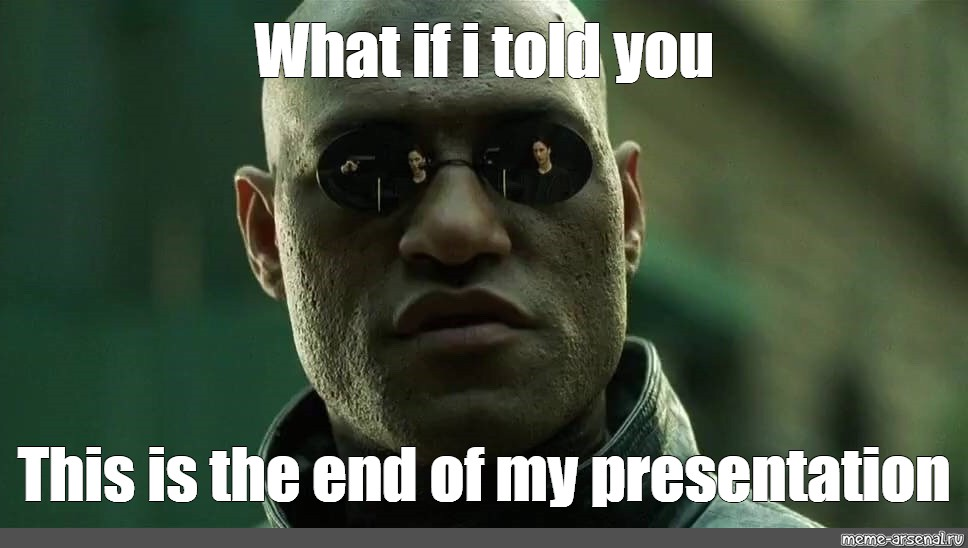

## APPROACH 2 : Collaborative Filtering RECOMMENDATION ENGINE

In [76]:
os.chdir(r'D:\MastersCollege\Semister 2\Study Materials\Intro_to_DS\Assignment\Notebook\data\processed')

In [78]:
Df2 = pd.read_excel('Data_final.xlsx')
Df2.drop(['Unnamed: 0'],1,inplace=True)

### Renaming Columns

In [79]:
Df2.columns = ['Restaurant', 'Cost', 'Collections', 'Cuisines', 'Rest_Timings',
       'Reviewer', 'Review', 'Rating', 'Time', 'Pictures', 'Review_counts',
       'Followers_counts']

In [80]:
Df2.head()

Restaurant  Cost                                        Collections  \
0  Beyond Flavours   800  Food Hygiene Rated Restaurants in Hyderabad, C...   
1  Beyond Flavours   800  Food Hygiene Rated Restaurants in Hyderabad, C...   
2  Beyond Flavours   800  Food Hygiene Rated Restaurants in Hyderabad, C...   
3  Beyond Flavours   800  Food Hygiene Rated Restaurants in Hyderabad, C...   
4  Beyond Flavours   800  Food Hygiene Rated Restaurants in Hyderabad, C...   

                                            Cuisines  \
0  Chinese, Continental, Kebab, European, South I...   
1  Chinese, Continental, Kebab, European, South I...   
2  Chinese, Continental, Kebab, European, South I...   
3  Chinese, Continental, Kebab, European, South I...   
4  Chinese, Continental, Kebab, European, South I...   

                                    Rest_Timings              Reviewer  \
0  12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)     Rusha Chakraborty   
1  12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)  Anusha Tirumalaneedi   
2  12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)       Ashok Shekhawat   
3  12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)        Swapnil Sarkar   
4  12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)                Dileep   

                                              Review  Rating             Time  \
0  The ambience was good, food was quite good . h...     5.0  5/25/2019 15:54   
1  Ambience is too good for a pleasant evening. S...     5.0  5/25/2019 14:20   
2  A must try.. great food great ambience. Thnx f...     5.0  5/24/2019 22:54   
3  Soumen das and Arun was a great guy. Only beca...     5.0  5/24/2019 22:11   
4  Food is good.we ordered Kodi drumsticks and ba...     5.0  5/24/2019 21:37   

   Pictures  Review_counts  Followers_counts  
0         0              1                 2  
1         0              3                 2  
2         0              2                 3  
3         0              1                 1  
4         0              3                 2

In [81]:
def clean_text(text):
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)    
    return text

In [82]:
Df2.columns

Index(['Restaurant', 'Cost', 'Collections', 'Cuisines', 'Rest_Timings',
       'Reviewer', 'Review', 'Rating', 'Time', 'Pictures', 'Review_counts',
       'Followers_counts'],
      dtype='object')

### Subseting DF2

In [86]:
sub_data = Df2[['Restaurant', 'Reviewer','Collections','Rating', 'Review']]

In [87]:
#Map clean text function to Review Column
sub_data['Review'] = sub_data['Review'].apply(clean_text)

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_4600/2575910320.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### USING TF-IDF FOR FEATURE EXTRACTION
#### BOTH USER WISE AND RESTAURANT WISE

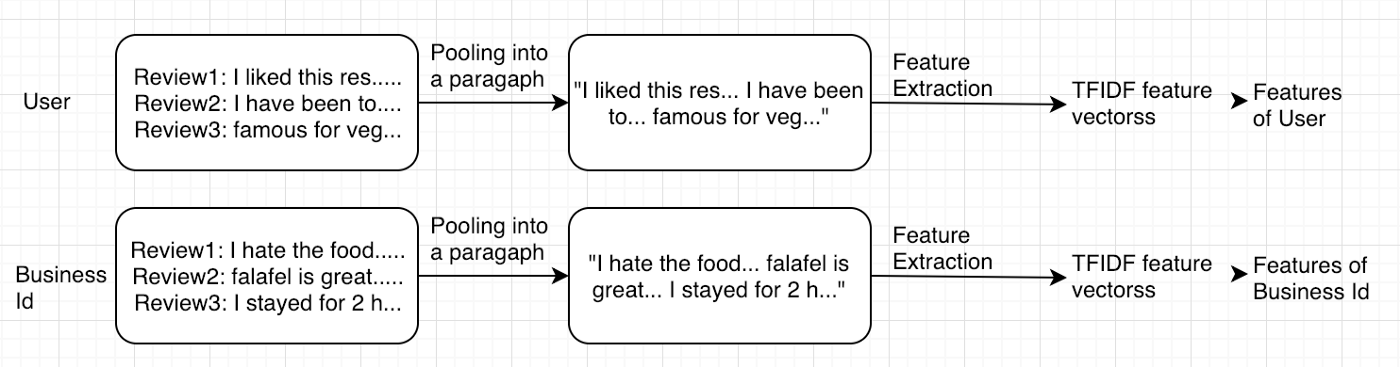

### USER-ID WISE VECTORIZATION 

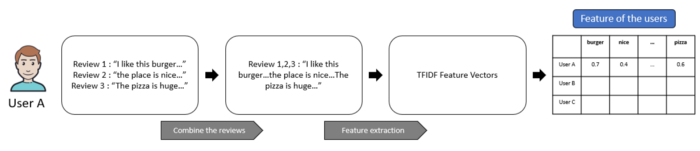

In [95]:
userid_df = sub_data[['Reviewer','Review']]
userid_df_grp = userid_df.groupby('Reviewer').agg({'Review':' '.join})

In [96]:
userid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=1000)
userid_vectors = userid_vectorizer.fit_transform(userid_df_grp['Review'])
userid_vectors.shape

(7446, 1000)

In [106]:
#MAKING DATAFRAME OF BAG OF WORDS
P = pd.DataFrame(userid_vectors.toarray(), index=userid_df_grp.index, columns=userid_vectorizer.get_feature_names())
P.head()

!         +         -    1       10    2  \
Reviewer                                                                       
#FOODPORN                    0.556213  0.000000  0.000000  0.0  0.33842  0.0   
#chloesviews // CAH          0.133907  0.096244  0.000000  0.0  0.00000  0.0   
$ign                         0.247012  0.000000  0.000000  0.0  0.00000  0.0   
4mybanti                     0.000000  0.000000  0.000000  0.0  0.00000  0.0   
@FuloriBinaChutneyKaiseBani  0.000000  0.000000  0.255258  0.0  0.00000  0.0   

                               3   30    4    5  ...  wow  wrap  wrong  yes  \
Reviewer                                         ...                          
#FOODPORN                    0.0  0.0  0.0  0.0  ...  0.0   0.0    0.0  0.0   
#chloesviews // CAH          0.0  0.0  0.0  0.0  ...  0.0   0.0    0.0  0.0   
$ign                         0.0  0.0  0.0  0.0  ...  0.0   0.0    0.0  0.0   
4mybanti                     0.0  0.0  0.0  0.0  ...  0.0   0.0    0.0  0.0   
@FuloriBinaChutneyKaiseBani  0.0  0.0  0.0  0.0  ...  0.0   0.0    0.0  0.0   

                             yesterday       yet  you  yum  yummy  zomato  
Reviewer                                                                   
#FOODPORN                          0.0  0.000000  0.0  0.0    0.0     0.0  
#chloesviews // CAH                0.0  0.245475  0.0  0.0    0.0     0.0  
$ign                               0.0  0.000000  0.0  0.0    0.0     0.0  
4mybanti                           0.0  0.000000  0.0  0.0    0.0     0.0  
@FuloriBinaChutneyKaiseBani        0.0  0.000000  0.0  0.0    0.0     0.0  

[5 rows x 1000 columns]

### BUSINESS ID WISE VECORIZATION

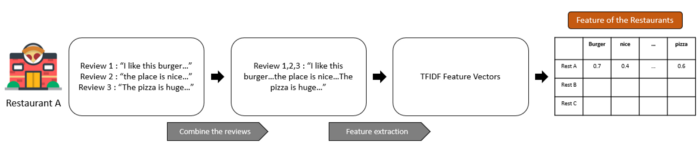

In [100]:
business_df = sub_data[['Restaurant', 'Review']]
business_df_grp = business_df.groupby('Restaurant').agg({'Review':' '.join})

In [101]:
businessid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=1000)
businessid_vectors = businessid_vectorizer.fit_transform(business_df_grp['Review'])
businessid_vectors.shape

(100, 1000)

In [105]:
Q = pd.DataFrame(businessid_vectors.toarray(), index=business_df_grp.index, columns=businessid_vectorizer.get_feature_names())
Q.head()

!         +         -         1  \
Restaurant                                                               
10 Downing Street               0.132722  0.610523  0.045575  0.003553   
13 Dhaba                        0.176859  0.349698  0.101488  0.005380   
3B's - Buddies, Bar & Barbecue  0.032551  0.303808  0.016437  0.000000   
AB's - Absolute Barbecues       0.033822  0.338223  0.017079  0.000000   
Absolute Sizzlers               0.045932  0.481073  0.017091  0.000000   

                                      10         2         3        30  \
Restaurant                                                               
10 Downing Street               0.029874  0.006351  0.035174  0.000000   
13 Dhaba                        0.012925  0.009617  0.000000  0.000000   
3B's - Buddies, Bar & Barbecue  0.000000  0.000000  0.005991  0.000000   
AB's - Absolute Barbecues       0.000000  0.000000  0.000000  0.000000   
Absolute Sizzlers               0.000000  0.005784  0.034703  0.004781   

                                       4         5  ...       wow  wrap  \
Restaurant                                          ...                   
10 Downing Street               0.055462  0.110468  ...  0.000000   0.0   
13 Dhaba                        0.018663  0.029274  ...  0.007359   0.0   
3B's - Buddies, Bar & Barbecue  0.009446  0.011289  ...  0.004967   0.0   
AB's - Absolute Barbecues       0.004908  0.021993  ...  0.007741   0.0   
Absolute Sizzlers               0.025255  0.060363  ...  0.013279   0.0   

                                   wrong       yes  yesterday       yet  \
Restaurant                                                                
10 Downing Street               0.008536  0.009149   0.004685  0.004468   
13 Dhaba                        0.000000  0.000000   0.021283  0.006766   
3B's - Buddies, Bar & Barbecue  0.000000  0.009349   0.000000  0.000000   
AB's - Absolute Barbecues       0.000000  0.014572   0.014924  0.000000   
Absolute Sizzlers               0.003887  0.000000   0.000000  0.000000   

                                     you       yum     yummy    zomato  
Restaurant                                                              
10 Downing Street               0.018862  0.000000  0.003409  0.002902  
13 Dhaba                        0.009521  0.000000  0.025813  0.030763  
3B's - Buddies, Bar & Barbecue  0.009638  0.005437  0.000000  0.000000  
AB's - Absolute Barbecues       0.015021  0.000000  0.005430  0.000000  
Absolute Sizzlers               0.008589  0.000000  0.003105  0.018502  

[5 rows x 1000 columns]

### PIVOTING A USER x RESTAURANT BASED MATRIX

In [104]:
userid_rating_matrix = pd.pivot_table(sub_data, values='Rating', index=['Reviewer'], columns=['Restaurant'])
userid_rating_matrix.shape
userid_rating_matrix.head()

(7446, 100)

Restaurant                   10 Downing Street  13 Dhaba  \
Reviewer                                                   
#FOODPORN                                  NaN       NaN   
#chloesviews // CAH                        NaN       NaN   
$ign                                       NaN       NaN   
4mybanti                                   NaN       NaN   
@FuloriBinaChutneyKaiseBani                NaN       NaN   

Restaurant                   3B's - Buddies, Bar & Barbecue  \
Reviewer                                                      
#FOODPORN                                               NaN   
#chloesviews // CAH                                     NaN   
$ign                                                    NaN   
4mybanti                                                NaN   
@FuloriBinaChutneyKaiseBani                             NaN   

Restaurant                   AB's - Absolute Barbecues  Absolute Sizzlers  \
Reviewer                                                                    
#FOODPORN                                          NaN                NaN   
#chloesviews // CAH                                NaN                NaN   
$ign                                               NaN                NaN   
4mybanti                                           NaN                NaN   
@FuloriBinaChutneyKaiseBani                        NaN                NaN   

Restaurant                   Al Saba Restaurant  American Wild Wings  Amul  \
Reviewer                                                                     
#FOODPORN                                   NaN                  NaN   NaN   
#chloesviews // CAH                         NaN                  NaN   NaN   
$ign                                        NaN                  NaN   NaN   
4mybanti                                    NaN                  NaN   NaN   
@FuloriBinaChutneyKaiseBani                 NaN                  NaN   NaN   

Restaurant                   Arena Eleven  Aromas@11SIX  ...  \
Reviewer                                                 ...   
#FOODPORN                             NaN           NaN  ...   
#chloesviews // CAH                   NaN           NaN  ...   
$ign                                  NaN           NaN  ...   
4mybanti                              NaN           NaN  ...   
@FuloriBinaChutneyKaiseBani           NaN           NaN  ...   

Restaurant                   The Tilt Bar Republic  Tiki Shack  Triptify  \
Reviewer                                                                   
#FOODPORN                                      NaN         NaN       NaN   
#chloesviews // CAH                            NaN         NaN       NaN   
$ign                                           NaN         NaN       NaN   
4mybanti                                       NaN         NaN       NaN   
@FuloriBinaChutneyKaiseBani                    NaN         NaN       NaN   

Restaurant                   Udipi's Upahar  Ulavacharu  \
Reviewer                                                  
#FOODPORN                               NaN         NaN   
#chloesviews // CAH                     NaN         NaN   
$ign                                    NaN         NaN   
4mybanti                                NaN         2.0   
@FuloriBinaChutneyKaiseBani             NaN         NaN   

Restaurant                   Urban Asia - Kitchen & Bar  \
Reviewer                                                  
#FOODPORN                                           NaN   
#chloesviews // CAH                                 NaN   
$ign                                                NaN   
4mybanti                                            NaN   
@FuloriBinaChutneyKaiseBani                         NaN   

Restaurant                   Yum Yum Tree - The Arabian Food Court  \
Reviewer                                                             
#FOODPORN                                                      NaN   
#chloesviews // CAH           

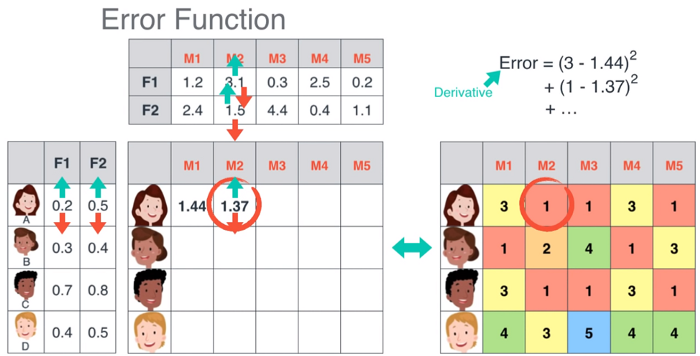

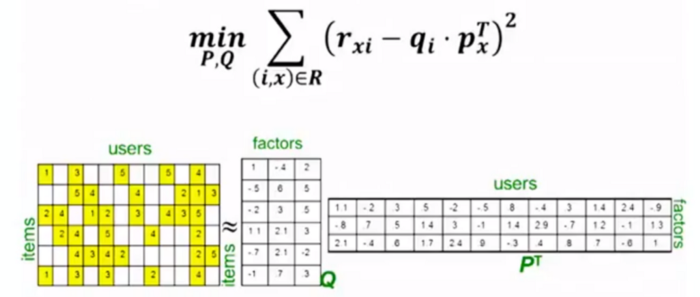

## COST FUNCTION

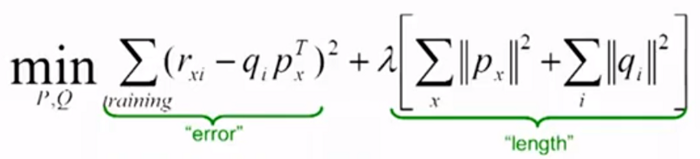

In [107]:
userid_rating_matrix =  userid_rating_matrix.fillna(0)

In [109]:
def matrix_factorization(R,P,Q,steps=100,gamma=0.001,lamda=0.02):
    for step in range(steps):
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    eij=R.loc[i,j]-np.dot(P.loc[i],Q.loc[j])
                    P.loc[i]=P.loc[i]+gamma*(eij*Q.loc[j]-lamda*P.loc[i])
                    Q.loc[j]=Q.loc[j]+gamma*(eij*P.loc[i]-lamda*Q.loc[j])
        e=0
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    e= e + pow(R.loc[i,j]-np.dot(P.loc[i],Q.loc[j]),2)+lamda*(pow(np.linalg.norm(P.loc[i]),2)+pow(np.linalg.norm(Q.loc[j]),2))
        if e<0.001:
            break
        
    return P,Q

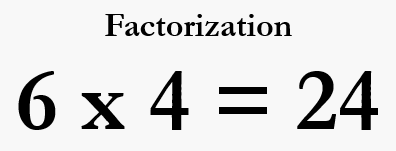

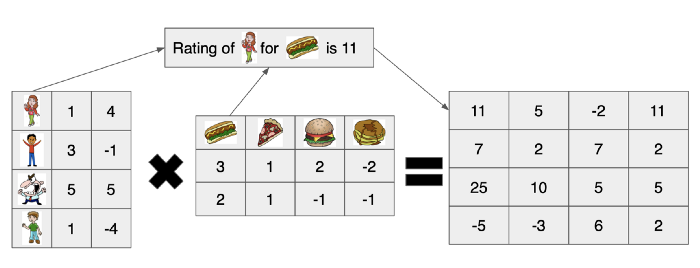

In [110]:
%%time
P, Q = matrix_factorization(userid_rating_matrix, P, Q, steps=100, gamma=0.001,lamda=0.02)

Wall time: 1h 3min 55s


In [111]:
#Store P, Q and vectorizer in pickle file
import pickle
output = open('recommendation_FINAL.pkl', 'wb')
pickle.dump(P,output)
pickle.dump(Q,output)
pickle.dump(userid_vectorizer,output)
output.close()

## TESTING

In [112]:
sentence = 'I want to eat chicken'
test_df= pd.DataFrame([sentence], columns=['text'])
test_df['text'] = test_df['text'].apply(clean_text)


In [113]:
test_vectors = userid_vectorizer.transform(test_df['text'])

In [114]:
test_v_df = pd.DataFrame(test_vectors.toarray(), index=test_df.index, columns=userid_vectorizer.get_feature_names())

In [115]:
predict_item_rating=pd.DataFrame(np.dot(test_v_df.loc[0],Q.T),index=Q.index,columns=['Rating'])
top_recommendations=pd.DataFrame.sort_values(predict_item_rating,['Rating'],ascending=[0])[:10]

In [116]:
top_recommendations

Rating
Restaurant                          
eat.fit                     0.872634
The Foodie Monster Kitchen  0.781561
Al Saba Restaurant          0.739850
Hotel Zara Hi-Fi            0.717280
Tandoori Food Works         0.622820
KFC                         0.622299
GD's                        0.596399
American Wild Wings         0.584092
Eat India Company           0.572351
Absolute Sizzlers           0.568902

In [128]:
import pandas_profiling as pp

In [129]:
profile = pp.ProfileReport(Data_final)
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]